Si è visto come il modello migliori piano piano facendo preprocessing e considerando le opportune variabili.
Una particolarità di questo dataset è che le caratteristiche sono poco correlate alla variabile target. A tal proposito si potrebbe pensare di effettuare un'ingegnerizzazione delle caratteristiche con opportune combinazioni, tentando, grazie a queste combinazioni, di aumentare la correlazione con il target. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluation


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import boxcox

In [2]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)

# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)
max_area = df['log_area'].max()

# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)

df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'], inplace=True)

Rimozione outliers come nella versione 2

In [3]:
# Copia del DataFrame originale, per non alterarlo direttamente
df_clean = df.copy()

df_clean = df_clean[(df_clean['FFMC'] >= 50)]
df_clean = df_clean[(df_clean['DC'] > 0)]
df_clean = df_clean[(df_clean['ISI'] < 50)]
df_clean = df_clean[(df_clean['log_area'] <= max_area)]


print(f"Dimensione originale del DataFrame: {df.shape}")
print(f"Dimensione del DataFrame senza outliers: {df_clean.shape}")

Dimensione originale del DataFrame: (517, 12)
Dimensione del DataFrame senza outliers: (515, 12)


Creazione nuove caratteristiche a partire dalle precedenti (vedere README per approfondire il significato delle caratteristiche).

- DISTANCE FROM CENTER -> nuova feature che rappresenta la distanza di ogni punto geografico dal centro del parco.
- FIRE DANGER INDEX -> nuovo indice basato su una combinazione degli indici di pericolo d'incendio.
- HUMIDITY DIFF -> differenza di umidità calcolata come FFMC - DMC.
- TEMP HUMIDITY INDEX -> appresenta l'interazione tra temperatura e umidità relativa.
- WIND RAIN INTERACTION -> nuova feature che combina la velocità del vento e l'effetto della pioggia (divisione per 6.4 normalizza la pioggia rispetto al massimo osservato).
- ARIDITY INDEX ->  indice di aridità basato su temperatura, umidità e vento.
- RAIN TEMP INTERACTION -> combina l'effetto della pioggia e della temperatura


<Axes: title={'center': 'Features Correlation'}>

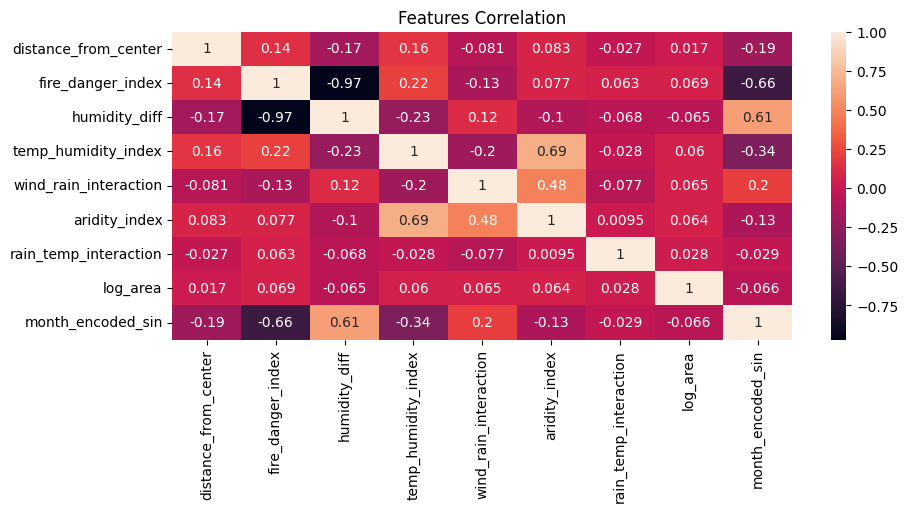

In [4]:
# Creazione delle nuove feature

df_clean_new = df.copy()

# 1. Coordinate spaziali
X_center, Y_center = 5, 5
df_clean_new['distance_from_center'] = np.sqrt((df_clean_new['X'] - X_center)**2 + (df_clean_new['Y'] - Y_center)**2)

# 3. Indici del sistema di pericolo d'incendio
df_clean_new['fire_danger_index'] = df_clean_new['FFMC'] * df_clean_new['ISI'] + df_clean_new['DMC'] * df_clean_new['DC']
df_clean_new['humidity_diff'] = df_clean_new['FFMC'] - df_clean_new['DMC']

# 4. Condizioni meteorologiche
df_clean_new['temp_humidity_index'] = df_clean_new['temp'] * (100 - df_clean_new['RH'])
df_clean_new['wind_rain_interaction'] = df_clean_new['wind'] * (1 - df_clean_new['rain'] / 6.4)
df_clean_new['aridity_index'] = df_clean_new['temp'] * (1 - df_clean_new['RH']/100) * df_clean_new['wind']

# 5. Raggruppamento temporale
df_clean_new['rain_temp_interaction'] = df_clean_new['rain'] * df_clean_new['temp']

# Selezione delle feature da mantenere (esempio)
features = [ 'distance_from_center', 'fire_danger_index', 'humidity_diff', 
            'temp_humidity_index', 'wind_rain_interaction', 'aridity_index','rain_temp_interaction', 'log_area', 'month_encoded_sin']

# Seleziona solo le colonne create
df_new = df_clean_new[features]
df_new

plt.figure(figsize=(10,4))
plt.title('Features Correlation')

sns.heatmap(df_new.corr(), annot=True) # Usa la correlazione di Pearson

MODELLI:

- LINEAR REGRESSOR:

Mean Absolute Error: 1.1968807819457246 -> km^2 = 0.023097768888826118
Train error (MAE): 1.118454259631846
------------
Mean Squared Error: 2.2186334229426223
Root Mean Squared Error: 1.4895077787452546 -> km^2 = 0.03434912023705358
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 78.71%
------------
Accuracy in percentage (with a tolerance of 5.0%): 14.42%
Accuracy in percentage (with a tolerance of 10.0%): 17.31%
Accuracy in percentage (with a tolerance of 25.0%): 80.77%
Accuracy in percentage (with a tolerance of 50.0%): 95.19%


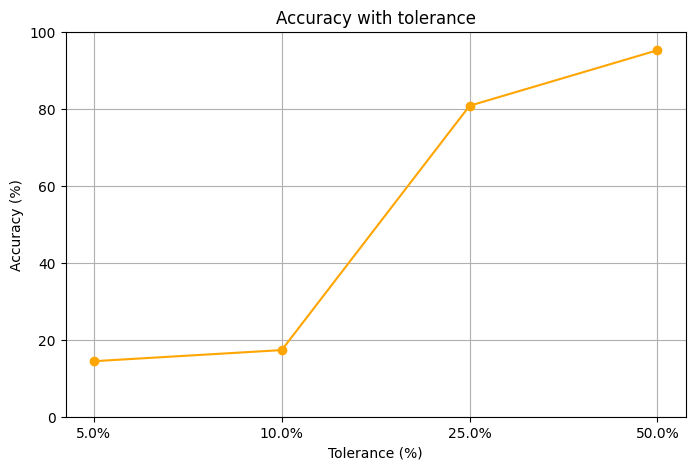

In [5]:
# LINEAR REGRESSOR

X = df_new.drop(['log_area'], axis=1)  # Features
y = df_new['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni  sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
print('- LINEAR REGRESSOR:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Best parameters: {'C': 1, 'gamma': 0.1}
- SVM:

Mean Absolute Error: 1.133739043527318 -> km^2 = 0.021072529608497047
Train error (MAE): 0.9556174749036942
------------
Mean Squared Error: 2.505638427122861
Root Mean Squared Error: 1.5829208530823204 -> km^2 = 0.03869157153804398
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 77.37%
------------
Accuracy in percentage (with a tolerance of 5.0%): 23.08%
Accuracy in percentage (with a tolerance of 10.0%): 40.38%
Accuracy in percentage (with a tolerance of 25.0%): 78.85%
Accuracy in percentage (with a tolerance of 50.0%): 94.23%


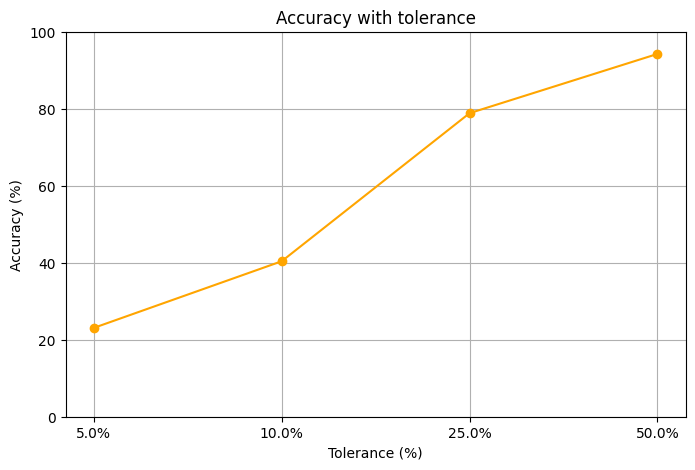

In [6]:
# SVM

X = df_new.drop(['log_area'], axis=1)  # Features
y = df_new['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = SVR(kernel='rbf')
#model.fit(X_train, y_train)

# Parametri da esplorare con GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Penalità dell'errore
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Flessibilità del kernel RBF
}
# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)


# Valutazione performace
print('- SVM:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:  {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
- NN:

Mean Absolute Error: 1.189265525735658 -> km^2 = 0.022846678172264653
Train error (MAE): 1.1220369673878
------------
Mean Squared Error: 2.147723183107701
Root Mean Squared Error: 1.4655112360905669 -> km^2 = 0.03329756202213503
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 79.05%
------------
Accuracy in percentage (with a tolerance of 5.0%): 11.54%
Accuracy in percentage (with a tolerance of 10.0%): 19.23%
Accuracy in percentage (with a tolerance of 25.0%): 79.81%
Accuracy in percentage (with a tolerance of 50.0%): 96.15%


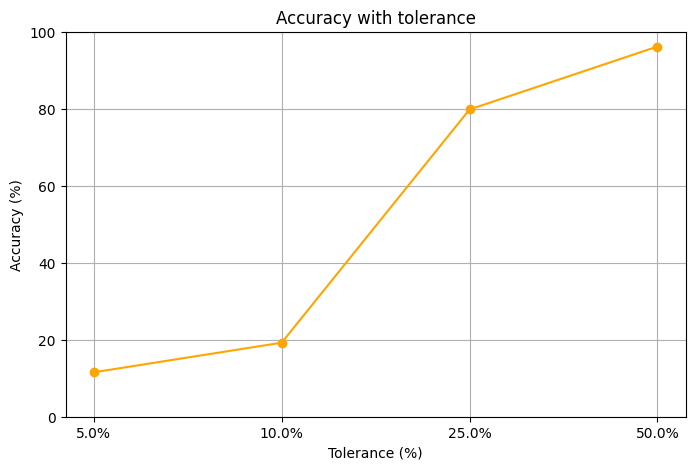

In [7]:
# NN 
X = df_new.drop(['log_area'], axis=1)  # Features
y = df_new['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = MLPRegressor(max_iter=1000, random_state=42)

# Parametri da ottimizzare
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],  # Diversi layer e dimensioni
    'activation': ['relu', 'tanh'],  # Funzioni di attivazione
    'solver': ['adam', 'sgd'],  # Algoritmi di ottimizzazione
    'alpha': [0.00001, 0.0001, 0.001, 0.01],  # Penalizzazione L2
    'learning_rate': ['constant', 'adaptive'],  # Velocità di apprendimento
}


# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=mae_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- NN:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
- GRADIENT BOOST REGRESSION:

Mean Absolute Error: 1.1683663783412355 -> km^2 = 0.022167334185272863
Train error (MAE): 1.077870837761673
------------
Mean Squared Error: 2.093341361796683
Root Mean Squared Error: 1.4468384021018668 -> km^2 = 0.03249657545251381
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 79.32%
------------
Accuracy in percentage (with a tolerance of 5.0%): 9.62%
Accuracy in percentage (with a tolerance of 10.0%): 17.31%
Accuracy in percentage (with a tolerance of 25.0%): 79.81%
Accuracy in percentage (with a tolerance of 50.0%): 95.19%


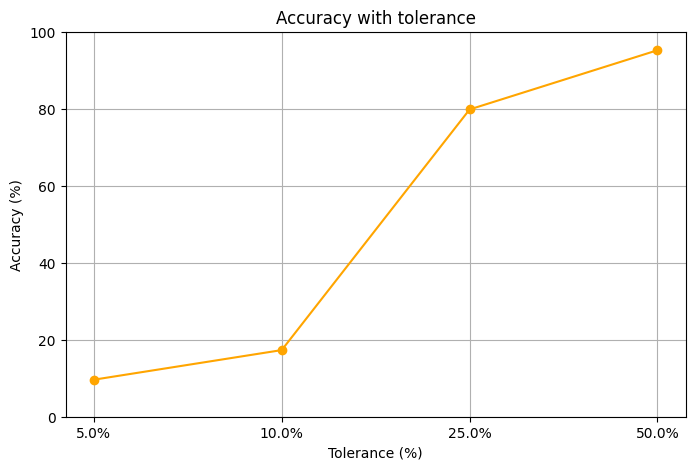

In [8]:
# GRADIENT BOOST REGRESSION
X = df_new.drop(['log_area', 'month_encoded_sin'], axis=1)
#X = df[['temp', 'RH', 'wind', 'rain']]
y = df_new['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Parametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 5, 7, 10],                # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Minimo numero di campioni per split
    'min_samples_leaf': [1, 2, 4],         # Minimo numero di campioni in una foglia
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid Search con validazione incrociata
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit dei dati di addestramento
grid_search.fit(X_train, y_train)

# Miglior modello
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- GRADIENT BOOST REGRESSION:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)